<div>
    <div class="row" style="color: #FFFFFF;font-size: 10px;padding-bottom: 20px">
        <div class="col-md-7">
        <img src="https://www.uoc.edu/portal/system/modules/edu.uoc.presentations/resources/img/branding/logo-uoc-default.png" alt="Logo UOC" style="margin:10px 0px 0px; width: 70px;">
        </div>
        <div class="col-md-5">
            <h1 style="margin:15px 0px 0px;font-size: 40px;">PRA2 - Projecte de mineria de dades</h1>
            <div style="text-align:left;margin-top: 5px;"></div>
        </div>
    </div>
    <div class="row" style="background: #00CCFF;color: #000000;font-size: 25px;padding: 5px 12px;">
        <div class="col-md-6">
            <div>Mineria de dades</div>
        </div>
        <div class="col-md-6" style="font-size: 14px;">
            <div style="text-align:left;">Autor: Marc Nosàs Pomares <br>
        </div>
        <div class="col-md-6" style="font-size: 14px;">
            <div style="text-align:left;">Data realització: 10 de Gener de 2024 <br>
        </div>
    </div>
</div>

Aquest és el document amb el codi utilitzat per a la realització de la pràctica, el complementaré amb un informe explicant cada un els passos seguits.

Aquest document és la continuació del document de la pràctica 1, per tant, començarem obrint les dades processades en la pràctica 1. I resoldrem els 7 exercicis plantejats en aquesta segona part

In [69]:
# obrim les llibreries que necessitarem per al processament i obrim el fitxer

import pandas as pd # https://pandas.pydata.org/docs/
import numpy as np
import matplotlib.pyplot as plt # https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
import seaborn as sns # https://seaborn.pydata.org/
import os


from sklearn.cluster import KMeans # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import DBSCAN, OPTICS # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

from sklearn.model_selection import train_test_split # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.ensemble import RandomForestClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.tree import export_graphviz, plot_tree
from treeinterpreter import treeinterpreter as ti

from sklearn.ensemble import GradientBoostingClassifier

# obrim el fitxer i el guardem en una variable
df = pd.read_csv('Data\practica1_result.csv')
# DEfinim la seed per a tota la practica.
seed = 20240110
os.environ['LOKY_MAX_CPU_COUNT'] = '2'

In [28]:
# df.cancelada_disc.value_counts()/df.shape[0]
# df.shape

Generaré una funció per a caluclar la precisió, la sensibilitat i la F-measure amb la matriu de confusió que ens doni cada model.

In [3]:
# Generaré una funció per a caluclar la precisió, la sensibilitat i la F-measure amb la matriu de confusió que ens doni cada model.
def metriques_qualitat(confusion_matrix):
    accuracy = (confusion_matrix[0,0]+confusion_matrix[1,1])/(confusion_matrix[0,0]+confusion_matrix[0,1]+confusion_matrix[1,0]+confusion_matrix[1,1])
    sensitivity = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
    f_measure = 2*sensitivity*accuracy/(sensitivity+accuracy)
    # I la confusion matrix en percentatges
    confusion_matrix = confusion_matrix/np.sum(confusion_matrix)
    return accuracy, sensitivity, f_measure, confusion_matrix

#### Exercici 1 (25%)
- Es genera un model no supervisat.
- S’analitzen, mostren i comenten les mesures de qualitat del model generat.
- Es resumeixen les conclusions principals.

In [4]:
df_prev = df.copy() # Guardem el dataframe original per als propers exercicis
# Convert boolean to int
df['cancelada_disc'] = df['cancelada_disc'].astype(int)

# Separate features and target
X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']

# Build KMeans model
kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10).fit(X)

# Assign clusters to entries
df['clusters'] = kmeans.labels_

# Find cluster centers
centroids = kmeans.cluster_centers_

# Identify which cluster is closer to True or False
true_center = [1 if i==0 else 0 for i in range(X.shape[1])]
false_center = [0 for i in range(X.shape[1])]
true_cluster = np.argmin([np.linalg.norm(centroid-true_center) for centroid in centroids])
false_cluster = np.argmin([np.linalg.norm(centroid-false_center) for centroid in centroids])

In [5]:
# Tornem a passar a boolea la columna de cancelada_disc
df['pred_cancelada_disc'] = df['clusters'] == true_cluster

# Mirem la accuracy, f1 i confusion matrix
accuracy = accuracy_score(df['cancelada_disc'], df['pred_cancelada_disc'])
f1 = f1_score(df['cancelada_disc'], df['pred_cancelada_disc'])
confusion = confusion_matrix(df['cancelada_disc'], df['pred_cancelada_disc'])
qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')

print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')


QUALITAT:
Exactitud: 40.51%
Precisió: 62.13%
F-measure: 49.04%
TRUE-TRUE: 27.52% | FALSE-TRUE: 7.92%
TRUE-FALSE: 51.57% | FALSE-FALSE: 12.99%


#### Exercici 2 (10%)
- Es genera de nou el model no supervisat anterior, però usant una mètrica de distància diferent.
- Es mostren i es comenten les mesures de qualitat del model generat.
- Addicionalment, es comparen els dos models no supervisats amb mètriques de distància diferents.
- Es resumeixen les conclusions principals.

In [6]:
from sklearn import preprocessing


In [10]:
# Utilitzem K-means amb la metrica cosine,
df = df_prev.copy()
# Convert boolean to int
df['cancelada_disc'] = df['cancelada_disc'].astype(int)

# Separate features and target
X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']


kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10).fit(preprocessing.normalize(X))

# Assign clusters to entries
df['clusters'] = kmeans.labels_

# Find cluster centers
centroids = kmeans.cluster_centers_

# Identify which cluster is closer to True or False
true_center = [1 if i==0 else 0 for i in range(X.shape[1])]
false_center = [0 for i in range(X.shape[1])]
true_cluster = np.argmin([np.linalg.norm(centroid-true_center) for centroid in centroids])
false_cluster = np.argmin([np.linalg.norm(centroid-false_center) for centroid in centroids])

In [11]:
# Tornem a passar a boolea la columna de cancelada_disc
df['pred_cancelada_disc'] = df['clusters'] == true_cluster

# Mirem la accuracy, f1 i confusion matrix
accuracy = accuracy_score(df['cancelada_disc'], df['pred_cancelada_disc'])
f1 = f1_score(df['cancelada_disc'], df['pred_cancelada_disc'])
confusion = confusion_matrix(df['cancelada_disc'], df['pred_cancelada_disc'])
qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')

print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')


QUALITAT:
Exactitud: 40.53%
Precisió: 62.11%
F-measure: 49.05%
TRUE-TRUE: 27.54% | FALSE-TRUE: 7.92%
TRUE-FALSE: 51.55% | FALSE-FALSE: 12.99%


#### Exercici 3 (10%)
- S’apliquen els algorismes DBSCAN i OPTICS de forma correcta.
- Es proven, descriuen i interpreten els resultats amb diferents valors d’eps i minPts.
- S’obté una mesura de com és de bo l’agrupament.
- Es comparen els resultats obtinguts dels models dels exercicis 1 i 2.
- Es resumeixen les conclusions principals.

In [6]:
# Tornem al original:
df = df_prev.copy() # Add .copy() to explicitly tell pandas that df is a new DataFrame
# En aquest cas per poder treballar reduirem el número de registres als 20000 primers
df = df.head(10000)
X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']

dbscan = DBSCAN(eps=0.5).fit(X)
df.loc[:, 'clusters'] = dbscan.labels_ # Modify the DataFrame using .loc[]
df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]
# Fem el dbscan per diferents valors de epsilon
epsilons = np.linspace(0.3, 1, 50)
results = []
for eps in epsilons:
    dbscan = DBSCAN(eps=eps).fit(X)
    df.loc[:, 'clusters'] = dbscan.labels_ # Modify the DataFrame using .loc[]
    df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]
    accuracy = accuracy_score(y, df['pred_cancelada_disc'])
    f1 = f1_score(y, df['pred_cancelada_disc'])
    confusion = confusion_matrix(y, df['pred_cancelada_disc'])
    num_clusters = len(np.unique(df['clusters']))
    results.append([eps, accuracy, f1, confusion, num_clusters])


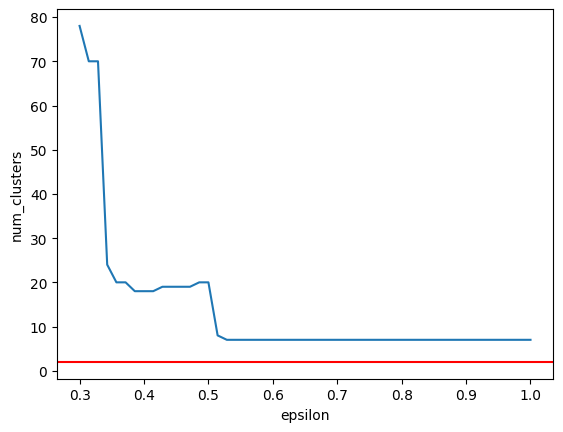

In [7]:
# Convertim la llista de resultats en un dataframe
results_df = pd.DataFrame(results, columns=['epsilon', 'accuracy', 'f1', 'confusion', 'num_clusters'])
# plotegem el número de clusters per a cada epsilon
plt.plot(results_df['epsilon'], results_df['num_clusters'])
plt.xlabel('epsilon')
plt.ylabel('num_clusters')
# Generem una linia en n = 2
plt.axhline(2, color='red')
# Guardem la imatge
plt.savefig('plots/epsilons.png')
plt.show()

In [22]:
df = df_prev.copy() # Un cop detectat el valor de epsilon optim podem tornar a fer el mateix procediment amb tot el dataset
df = df.head(70000)
X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']

dbscan = DBSCAN(eps=0.5, n_jobs=-1).fit(X) # job -1 es per a que utilitzi tots els cores disponibles
df.loc[:, 'clusters'] = dbscan.labels_ # Modify the DataFrame using .loc[]
df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]

accuracy = accuracy_score(y, df['pred_cancelada_disc'])
f1 = f1_score(y, df['pred_cancelada_disc'])
confusion = confusion_matrix(y, df['pred_cancelada_disc'])

qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')

print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')

QUALITAT:
Exactitud: 74.99%
Precisió: 2.57%
F-measure: 4.96%
TRUE-TRUE: 74.38% | FALSE-TRUE: 23.32%
TRUE-FALSE: 1.68% | FALSE-FALSE: 0.61%


In [19]:
# Ara intentem que hi hagi mitat i mitat de registres de cada classe
df = df_prev.copy()
# Trenquem per cancelada_disc= True
df_false = df[df['cancelada_disc']==True]
df_true = df[df['cancelada_disc']==False]
# I ara agafem els primers n registres de df_false on n es el número de registres de df_true
df_true = df_true.head(df_false.shape[0])
# I tornem a unir els dos dataframes
df = pd.concat([df_true, df_false])
# Ho barregem de forma aleatoria i agafem 50000 registres
df = df.sample(50000, random_state=seed)

X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']

dbscan = DBSCAN(eps=0.5, n_jobs=-1).fit(X) # job -1 es per a que utilitzi tots els cores disponibles
df.loc[:, 'clusters'] = dbscan.labels_ # Modify the DataFrame using .loc[]
df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]
confusion = confusion_matrix(y, df['pred_cancelada_disc'])
qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')
print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')


QUALITAT:
Exactitud: 50.13%
Precisió: 1.08%
F-measure: 2.11%
[[24797   307]
 [24628   268]]


In [17]:
# Tornem al original:
df = df_prev.copy() # Add .copy() to explicitly tell pandas that df is a new DataFrame
# En aquest cas per poder treballar reduirem el número de registres als 20000 primers
df = df.head(10000)
X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']

# Fem el optics per diferents valors de min_samples
min_samples_list = range(5, 105, 10)
results = []
for min_samples in min_samples_list:
    optics = OPTICS(min_samples=min_samples).fit(X)
    df.loc[:, 'clusters'] = optics.labels_ # Modify the DataFrame using .loc[]
    df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]
    num_clusters = len(np.unique(df['clusters']))
    results.append([min_samples, num_clusters])

c:\Users\MarcNosas\.conda\envs\UOC\Lib\site-packages\sklearn\cluster\_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


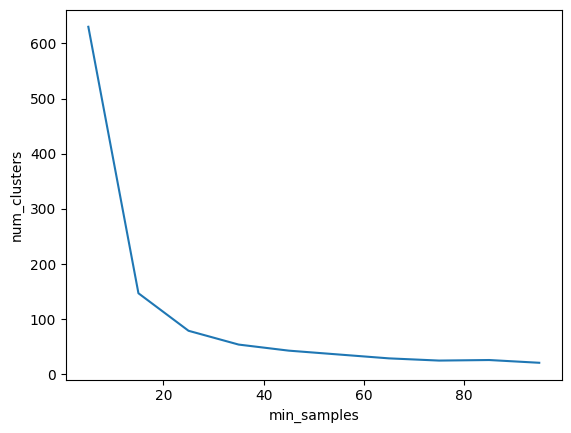

In [19]:
# Convertim la llista de resultats en un dataframe
results_df = pd.DataFrame(results, columns=['min_samples','num_clusters'])
# plotegem el número de clusters per a cada min_samples
plt.plot(results_df['min_samples'], results_df['num_clusters'])
plt.xlabel('min_samples')
plt.ylabel('num_clusters')
# Guardem la imatge
plt.savefig('plots/min_samples.png')
plt.show()

In [20]:
# Al voltant de 100 tenim el valor optim
df = df_prev.copy() # Un cop detectat el valor de epsilon optim podem tornar a fer el mateix procediment amb tot el dataset
df = df.head(70000)
X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']

optics = OPTICS(min_samples=30, n_jobs=-1).fit(X) # job -1 es per a que utilitzi tots els cores disponibles
df.loc[:, 'clusters'] = optics.labels_ # Modify the DataFrame using .loc[]
df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]
confusion = confusion_matrix(y, df['pred_cancelada_disc'])
qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')
print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')

QUALITAT:
Exactitud: 76.01%
Precisió: 0.02%
F-measure: 0.05%
TRUE-TRUE: 76.01% | FALSE-TRUE: 23.93%
TRUE-FALSE: 0.05% | FALSE-FALSE: 0.01%


In [22]:
# Al voltant de 100 tenim el valor optim
df = df_prev.copy() # Un cop detectat el valor de epsilon optim podem tornar a fer el mateix procediment amb tot el dataset
df = df.head(70000)
X = df.drop('cancelada_disc', axis=1)
# Ara agafem només les columnes: antelacion_dias_disc i booking_date
X = X[['antelacion_dias_disc', 'booking_date']]
y = df['cancelada_disc']

optics = OPTICS(min_samples=30, n_jobs=-1).fit(X) # job -1 es per a que utilitzi tots els cores disponibles
df.loc[:, 'clusters'] = optics.labels_ # Modify the DataFrame using .loc[]
df.loc[:, 'pred_cancelada_disc'] = df['clusters'] == 0 # Modify the DataFrame using .loc[]
confusion = confusion_matrix(y, df['pred_cancelada_disc'])
qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')
print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')

QUALITAT:
Exactitud: 76.02%
Precisió: 0.09%
F-measure: 0.18%
TRUE-TRUE: 76.00% | FALSE-TRUE: 23.92%
TRUE-FALSE: 0.06% | FALSE-FALSE: 0.02%


### Exercici 4 (10%)
- Se seleccionen les mostres d’entrenament i test.
- Es justifiquen les proporcions seleccionades.

In [24]:
# Tornem al original:
df = df_prev.copy() 

In [25]:
df.shape

(325437, 26)

In [30]:

X = df.drop('cancelada_disc', axis=1)
y = df['cancelada_disc']
# Fem el split en train i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Ara mirem les distribucions de cancelada_disc en train i test
print('Distribució de cancelada_disc en train:')
print(y_train.value_counts())
print('Distribució de cancelada_disc en test:')
print(y_test.value_counts())



Distribució de cancelada_disc en train:
cancelada_disc
False    205769
True      54580
Name: count, dtype: int64
Distribució de cancelada_disc en test:
cancelada_disc
False    51613
True     13475
Name: count, dtype: int64


Ara que ja tenim un training set apunt, ja podem començar amb l'aprenentatge supervisat.

### Exercici 5 (20%)
- Es generen regles i es comenten i interpreten les més significatives.
- S’extreuen les regles del model en format text i gràfic.
- Addicionalment, es genera matriu de confusió per mesurar la capacitat predictiva de l’algoritme,
tenint en compte les diferents mètriques associades a aquesta matriu (precisió, sensibilitat, especificitat. . . ).
- Es comparen i interpreten els resultats (sense i amb opcions de poda), explicant els avantatges i
els inconvenients del model generat respecte a un altre mètode de construcció.
- S’avalua la taxa d’error de l’arbre generat, l’eficiència a la classificació (a les mostres d’entrenament
i test) i la comprensibilitat del resultat.
- Es resumeixen les conclusions principals.

In [47]:
# Ara utilitzarem un Random Forest Classifier per a predir la variable target cancelada_disc

# Creem el model
rf = RandomForestClassifier(random_state=seed, n_estimators=3, max_depth=4)
# Entrenem el model
rf.fit(X_train, y_train)
# Fem prediccions
y_pred = rf.predict(X_test)

# Calculem la accuracy, f1 i confusion matrix
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

qual = metriques_qualitat(confusion)
print('QUALITAT:')
print(f'Exactitud: {qual[0]:.2%}')
print(f'Precisió: {qual[1]:.2%}')
print(f'F-measure: {qual[2]:.2%}')
print(f'TRUE-TRUE: {qual[3][0,0]:.2%} | FALSE-TRUE: {qual[3][1,0]:.2%}', )
print(f'TRUE-FALSE: {qual[3][0,1]:.2%} | FALSE-FALSE: {qual[3][1,1]:.2%}')


QUALITAT:
Exactitud: 79.32%
Precisió: 0.09%
F-measure: 0.18%
TRUE-TRUE: 79.30% | FALSE-TRUE: 20.68%
TRUE-FALSE: 0.00% | FALSE-FALSE: 0.02%


In [48]:
# Extract single tree
estimator = rf.estimators_[1]

In [49]:
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = [str(class_name) for class_name in rf.classes_],
                rounded = True, proportion = False, 
                precision = 2, filled = True)


In [51]:
# Plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(estimator, feature_names=X_train.columns, class_names=[str(class_name) for class_name in rf.classes_],
          filled=True, rounded=True, fontsize=10)
plt.savefig('tree.png', dpi=300)
plt.show()

In [59]:
# Ara provem diferents valors de n_estimators i max_depth per a veure quins donen millors resultats
n_estimators = range(1, 10)
max_depth = range(1, 101, 10)

# Ara provem amb n_estimators
results = []
for n in max_depth:
    rf = RandomForestClassifier(random_state=seed, n_estimators=1, max_depth=n)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    qual = metriques_qualitat(confusion)
    results.append([n, qual[0], qual[1]]) # Guardem exactitud i precisió

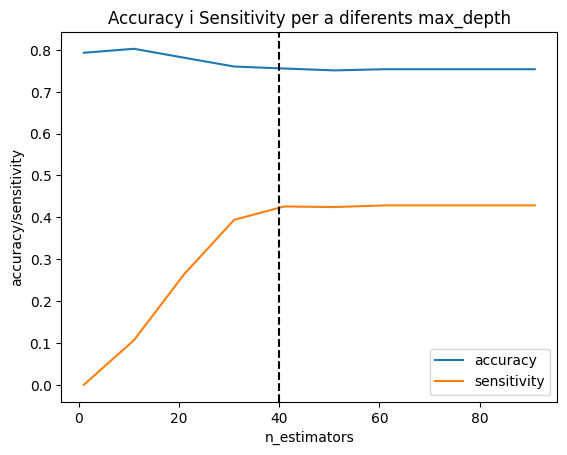

In [60]:
# Convertim la llista de resultats en un dataframe
results_df = pd.DataFrame(results, columns=['n_estimators', 'accuracy', 'sensitivity'])
# plotegem el número de clusters per a cada min_samples
plt.plot(results_df['n_estimators'], results_df['accuracy'], label='accuracy')
plt.plot(results_df['n_estimators'], results_df['sensitivity'], label='sensitivity')
plt.xlabel('n_estimators')
plt.ylabel('accuracy/sensitivity')
# Ahora generamos una linea vertical en n = 35
plt.axvline(40, color='black', linestyle='--')
plt.title('Accuracy i Sensitivity per a diferents max_depth')
plt.legend()
# Guardem la imatge
plt.savefig('plots/max_depth.png')
plt.show()

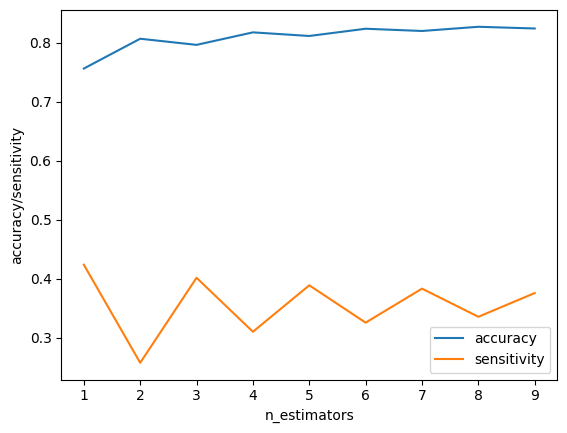

In [57]:
# Ara provem amb n_estimators
results = []
for n in n_estimators:
    rf = RandomForestClassifier(random_state=seed, n_estimators=n, max_depth=40)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    qual = metriques_qualitat(confusion)
    results.append([n, qual[0], qual[1]]) # Guardem exactitud i precisió


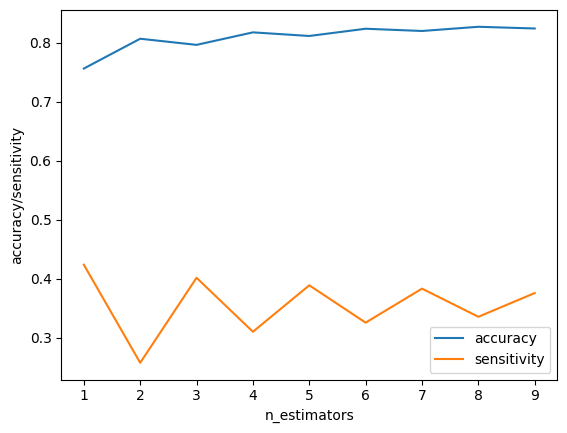

In [58]:
# Convertim la llista de resultats en un dataframe
results_df = pd.DataFrame(results, columns=['n_estimators', 'accuracy', 'sensitivity'])
# plotegem el número de clusters per a cada min_samples
plt.plot(results_df['n_estimators'], results_df['accuracy'], label='accuracy')
plt.plot(results_df['n_estimators'], results_df['sensitivity'], label='sensitivity')
plt.xlabel('n_estimators')
plt.ylabel('accuracy/sensitivity')
plt.legend()
# Guardem la imatge
plt.savefig('plots/n_estimators.png')
plt.show()

In [67]:
# Com que l'objectiu és maximitzar la sensitivitat, agafem el valor de n_estimators que ens dona la màxima sensitivitat
rf = RandomForestClassifier(random_state=seed, n_estimators=1, max_depth=40)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
qual = metriques_qualitat(confusion)

# imprimim les metriques de qualitat
print('QUALITAT:')
print(f'- Exactitud: {qual[0]:.2%}')
print(f'- Precisió: {qual[1]:.2%}')
print(f'- F-measure: {qual[2]:.2%}')

#  guardem un fitxer .dot amb l'arbre
export_graphviz(rf.estimators_[0], out_file='tree_complex.dot', 
                feature_names = X_train.columns,
                class_names = [str(class_name) for class_name in rf.classes_],
                rounded = True, proportion = False, 
                precision = 2, filled = True)


QUALITAT:
- Exactitud: 75.65%
- Precisió: 42.39%
- F-measure: 54.33%


<Axes: >

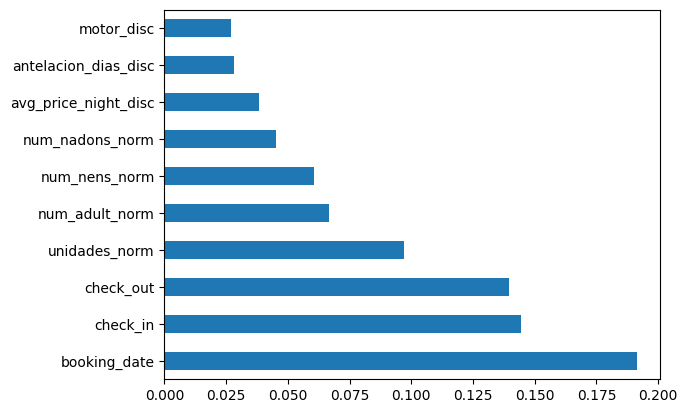

In [66]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

### Exercici 6 (15%)
- Es prova amb una variació o un altre enfocament algorítmic.
- Es detalla, comenta i avalua la qualitat de classificació.
- Es comparen i es comenten els resultats de manera exhaustiva amb el mètode de construcció
anterior.

In [72]:
# Ara utilitzarem un altre algoritme, Gradient Boosting Classifier
# Creem el model
gb = GradientBoostingClassifier(random_state=seed)
# Utilitzem el mateix train i test que abans
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
qual = metriques_qualitat(confusion)
# imprimim les metriques de qualitat
print('QUALITAT:')
print(f'- Exactitud: {qual[0]:.2%}')
print(f'- Precisió: {qual[1]:.2%}')
print(f'- F-measure: {qual[2]:.2%}')


QUALITAT:
- Exactitud: 80.04%
- Precisió: 6.25%
- F-measure: 11.59%


### Exercici 7 (10%)
- S’identifica quines possibles limitacions tenen les dades que has seleccionat per obtenir conclusions
amb els models (supervisat i no supervisat)
- S’identifiquen possibles riscos de fer servir el model (mínim 300 paraules).